# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/Guided Research/"

# Import Libraries

In [0]:
!pip install git+https://github.com/Behrouz-Babaki/COP-Kmeans.git --quiet

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import random

from copkmeans.cop_kmeans import cop_kmeans

# Calculate Embeddings / Weights


## Calculate Sentence Embeddings

In [0]:
def get_label_embeddings(df, embed):
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
        input_placeholder = tf.placeholder(tf.string, shape=(None))

        sentences = df['Sentence'].tolist()

        sentence_encodings = embed(input_placeholder)
        sentence_embeddings = session.run(sentence_encodings, feed_dict={input_placeholder: sentences})

        session.close()

    return sentence_embeddings

## Calculate Perception Uncertainty

In [0]:
def get_perception_uncertainty_values(input_matrix, col_data):
    # Calculate similarity with centroids
    similarity_with_centroids = np.inner(input_matrix, centers)

    # Weighted Sum of Similarities
    class_weights_weighted_similarity = get_class_weights(similarity_with_centroids.shape, col_data, weighted=True)
    pu_scores_weighted_similarity = np.sum(similarity_with_centroids * class_weights_weighted_similarity, axis=1)

    # Sum of Similarities - Unweighted
    class_weights_unweighted_similarity = get_class_weights(similarity_with_centroids.shape, col_data, weighted=False)
    pu_scores_unweighted_similarity = np.sum(similarity_with_centroids * class_weights_unweighted_similarity, axis=1)

    # Similarity with respective class centroid
    col_data_indices = [cluster_ordering.index(col_data[i]) for i in range(len(col_data))]
    pu_scores_similarity = similarity_with_centroids[np.arange(len(col_data_indices)), col_data_indices]

    return normalize(pu_scores_weighted_similarity), normalize(pu_scores_unweighted_similarity), normalize(pu_scores_similarity)

In [0]:
def normalize(arr):
    return (arr - arr.mean()) / arr.std()

### Calculate class weights

In [0]:
def get_class_weights(weight_shape, col_data, weighted):
    class_weights = np.ones(shape=weight_shape)
    for i in range(class_weights.shape[0]):
        class_weights[i][cluster_ordering.index(col_data[i])] = -1
        if weighted:
            class_weights[i] *= similarity_matrix_rows[col_data[i]]

    return class_weights

# Store Perception Uncertainty

In [0]:
def store_PU_scores(pu_scores_ws, pu_scores_uws, pu_scores, datasetType):
    df = pd.read_csv(dataset_path + datasetType + "/" + fileName)
    df[col_label+'_PU_WS'] = pu_scores_ws
    df[col_label+'_PU_uWS'] = pu_scores_uws
    df[col_label+'_PU_S'] = pu_scores
    df.to_csv(dataset_path + datasetType + "/" + fileName, encoding='utf-8',index=False)

# COP_KMEANS_FAST

In [0]:
"""
Code copied from the included library: https://github.com/Behrouz-Babaki/COP-Kmeans
The only difference is because of the changes I made, this version runs very fast,
since there's no checking for constraint violation which goes into exponential time,
and for the amount of constraints that we have, this is not feasible
"""
def cop_kmeans_fast(dataset, k, ml=[], cl=[], initialization='kmpp', max_iter=300, tol=1e-4):
    ml_info = get_ml_info(ml, dataset)
    tol = tolerance(tol, dataset)

    centers = initialize_centers(dataset, k, initialization)

    for _ in range(max_iter):
        clusters_ = [-1] * len(dataset)
        for i, d in enumerate(dataset):
            indices, _ = closest_clusters(centers, d)
            counter = 0
            if clusters_[i] == -1:
                found_cluster = False
                while (not found_cluster) and counter < len(indices):
                    index = indices[counter]
                    if not violate_constraints(i, index, clusters_, ml, cl):
                        found_cluster = True
                        clusters_[i] = index
                        for j in ml[i]:
                            clusters_[j] = index
                    counter += 1

                if not found_cluster:
                    return None, None

        clusters_, centers_ = compute_centers(clusters_, dataset, k, ml_info)
        shift = sum(l2_distance(centers[i], centers_[i]) for i in range(k))
        if shift <= tol:
            break

        centers = centers_

    return clusters_, centers_

def l2_distance(point1, point2):
    return sum([(float(i)-float(j))**2 for (i, j) in zip(point1, point2)])

# taken from scikit-learn (https://goo.gl/1RYPP5)
def tolerance(tol, dataset):
    n = len(dataset)
    dim = len(dataset[0])
    averages = [sum(dataset[i][d] for i in range(n))/float(n) for d in range(dim)]
    variances = [sum((dataset[i][d]-averages[d])**2 for i in range(n))/float(n) for d in range(dim)]
    return tol * sum(variances) / dim

def closest_clusters(centers, datapoint):
    distances = [l2_distance(center, datapoint) for
                 center in centers]
    return sorted(range(len(distances)), key=lambda x: distances[x]), distances

def initialize_centers(dataset, k, method):
    if method == 'random':
        ids = list(range(len(dataset)))
        random.shuffle(ids)
        return [dataset[i] for i in ids[:k]]

    elif method == 'kmpp':
        chances = [1] * len(dataset)
        centers = []

        for _ in range(k):
            chances = [x/sum(chances) for x in chances]
            r = random.random()
            acc = 0.0
            for index, chance in enumerate(chances):
                if acc + chance >= r:
                    break
                acc += chance
            centers.append(dataset[index])

            for index, point in enumerate(dataset):
                cids, distances = closest_clusters(centers, point)
                chances[index] = distances[cids[0]]

        return centers

def violate_constraints(data_index, cluster_index, clusters, ml, cl):
    for i in ml[data_index]:
        if clusters[i] != -1 and clusters[i] != cluster_index:
            return True

    for i in cl[data_index]:
        if clusters[i] == cluster_index:
            return True

    return False

def compute_centers(clusters, dataset, k, ml_info):
    cluster_ids = set(clusters)
    k_new = len(cluster_ids)
    id_map = dict(zip(cluster_ids, range(k_new)))
    clusters = [id_map[x] for x in clusters]

    dim = len(dataset[0])
    centers = [[0.0] * dim for i in range(k)]

    counts = [0] * k_new
    for j, c in enumerate(clusters):
        for i in range(dim):
            centers[c][i] += dataset[j][i]
        counts[c] += 1

    for j in range(k_new):
        for i in range(dim):
            centers[j][i] = centers[j][i]/float(counts[j])

    if k_new < k:
        ml_groups, ml_scores, ml_centroids = ml_info
        current_scores = [sum(l2_distance(centers[clusters[i]], dataset[i])
                              for i in group)
                          for group in ml_groups]
        group_ids = sorted(range(len(ml_groups)),
                           key=lambda x: current_scores[x] - ml_scores[x],
                           reverse=True)

        for j in range(k-k_new):
            gid = group_ids[j]
            cid = k_new + j
            centers[cid] = ml_centroids[gid]
            for i in ml_groups[gid]:
                clusters[i] = cid

    return clusters, centers

def get_ml_info(ml, dataset):
    flags = [True] * len(dataset)
    groups = []
    for i in range(len(dataset)):
        if not flags[i]: continue
        group = list(ml[i] | {i})
        groups.append(group)
        for j in group:
            flags[j] = False

    dim = len(dataset[0])
    scores = [0.0] * len(groups)
    centroids = [[0.0] * dim for i in range(len(groups))]

    for j, group in enumerate(groups):
        for d in range(dim):
            for i in group:
                centroids[j][d] += dataset[i][d]
            centroids[j][d] /= float(len(group))

    scores = [sum(l2_distance(centroids[j], dataset[i])
                  for i in groups[j])
              for j in range(len(groups))]

    return groups, scores, centroids


# Main

## Load Data

In [0]:
dataset_path = sharedGFolderPath + 'data/'

In [0]:
fileName = "dataframePerceptionUncertainty_SingleLabel.csv"
df = pd.read_csv(dataset_path + "train/" + fileName)
df.head()

,Sentence,Triplet,Coarse_Entity,Fine_Entity,Coarse_Attribute,Sentiment,Coarse_Attribute_PU_WS,Coarse_Attribute_PU_uWS,Coarse_Attribute_PU_S
0,Cookifi is one of the leading Organic caterers...,organic-trustworthy sources-0,organic,organic companies,trustworthy sources,0,-1.305144,-1.251783,-1.153170
1,"With over a 100 organic dishes, and customizab...",organic-experienced quality-p,organic,organic companies,experienced quality,p,-0.886723,-0.875631,-0.213775
2,As of now they have 3 full fledged Organic Men...,organic-trustworthy sources-0,organic,organic companies,trustworthy sources,0,-1.197772,-1.139302,-0.768746
3,Organic Menus From Cookifi,organic-general-0,organic,organic companies,general,0,-0.855961,-0.907718,-1.153074
4,Organic egg production is the production of eg...,organic-environment-0,organic,organic farmers,environment,0,0.487700,0.549867,0.424995


## Get Embeddings for Train Data

In [0]:
all_labels = {'Coarse_Entity': ['organic', 'conventional', 'GMO'], 'Coarse_Attribute': ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources', 'environment'],
              'Entity_Sentiment': ['organic-0', 'organic-p', 'organic-n', 'conventional-0', 'conventional-p', 'conventional-n', 'GMO-0', 'GMO-p', 'GMO-n'],
              'Triplet': [ent+'-'+att+'-'+sent for ent in ['organic', 'conventional', 'GMO'] for att in ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources',
                                                                                                         'environment'] for sent in ['0', 'p', 'n']],
              'Fine_Entity': ['organic general', 'organic products', 'organic farmers', 'organic companies', 'conventional general', 'conventional products', 'conventional farming',
                              'conventional companies','GMOs genetic engineering general']}

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [0]:
#load universal sentence encoder
embed = hub.Module(module_url)

In [0]:
input_matrix = get_label_embeddings(df, embed)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Calculate cluster centroids using PC-K-Means

In [0]:
col_label = 'Coarse_Attribute'
col_data = df[col_label].tolist()
col_label_categories = all_labels[col_label]

In [0]:
must_link = {i: set() for i in range(len(col_data))}
cannot_link = {i: set() for i in range(len(col_data))}

for i,label1 in enumerate(col_data):
    for j,label2 in enumerate(col_data):
        if i!=j:
            if label1==label2:
                must_link[i].add(j)
            else:
                cannot_link[i].add(j)

In [0]:
clusters, centers = cop_kmeans_fast(dataset=input_matrix, k=len(col_label_categories), ml=must_link,cl=cannot_link,initialization='random')

In [0]:
uniqueValues, occurCount = np.unique(clusters, return_counts=True)

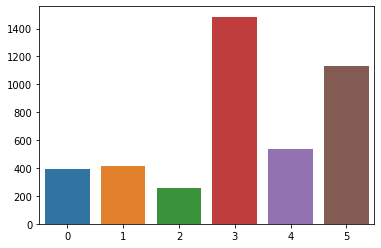

In [0]:
sns.barplot(uniqueValues, occurCount)

## Determine cluster mapping for centroids


---
Since we have the controids but not direct mapping to classes, we get that mapping implicitly from the size of clusters.


In [0]:
label_count_dict = df[col_label].value_counts().to_dict()
occurCount = list(occurCount)

In [0]:
cluster_mapping = {occurCount.index(label_count_dict[key]): key for key in label_count_dict}
cluster_ordering = [cluster_mapping[key] for key in sorted(cluster_mapping.keys())]

## Load similarity matrix, ordered by cluster mapping

In [0]:
similarity_matrix = pd.read_csv(dataset_path + "similarity_matrices/"+col_label+"_Similarity_Scores.csv", index_col=0)
similarity_matrix_rows = {label: similarity_matrix.loc[label, cluster_ordering].values for label in col_label_categories}

## Get All Perception Uncertainties

In [0]:
pu_scores_weighted_similarity, pu_scores_unweighted_similarity, pu_scores_similarity = get_perception_uncertainty_values(input_matrix, col_data)
store_PU_scores(pu_scores_weighted_similarity, pu_scores_unweighted_similarity, pu_scores_similarity, 'train')

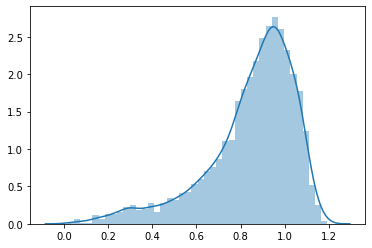

In [0]:
sns.distplot(pu_scores_weighted_similarity)

## Calculate Perception uncertainty for Validation / Test set

In [0]:
df_val = pd.read_csv(dataset_path + "validation/" + fileName)
df_test = pd.read_csv(dataset_path + "test/" + fileName)

val_embed = get_label_embeddings(df_val, embed)
test_embed = get_label_embeddings(df_test, embed)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
pu_scores_weighted_similarity, pu_scores_unweighted_similarity, pu_scores_similarity = get_perception_uncertainty_values(val_embed, df_val[col_label].tolist())
store_PU_scores(pu_scores_weighted_similarity, pu_scores_unweighted_similarity, pu_scores_similarity, 'validation')

In [0]:
pu_scores_weighted_similarity, pu_scores_unweighted_similarity, pu_scores_similarity = get_perception_uncertainty_values(test_embed, df_test[col_label].tolist())
store_PU_scores(pu_scores_weighted_similarity, pu_scores_unweighted_similarity, pu_scores_similarity, 'test')

## Use MinMaxScaler to scale values between 0 and 1 (If Needed)

In [0]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

In [0]:
import pandas as pd
dataset_path = sharedGFolderPath + 'data/'
fileName = "dataframePerceptionUncertainty_SingleLabel.csv"

In [0]:
datasetType = "train"
df = pd.read_csv(dataset_path + datasetType + "/" + fileName)

In [0]:
scaler = MinMaxScaler()
df['Coarse_Attribute_PU_S_Scaled'] = scaler.fit_transform(df['Coarse_Attribute_PU_S'].values.reshape(-1,1))

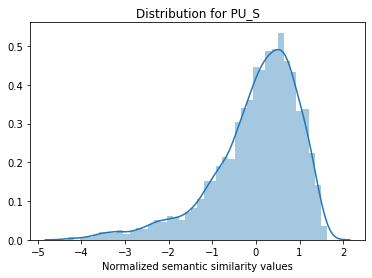

In [0]:
sns.distplot(df['Coarse_Attribute_PU_S'])
plt.xlabel('Normalized semantic similarity values')
plt.title('Distribution for PU_S')
plt.savefig('PU_S_dist.pdf')
plt.show()

In [0]:
df.to_csv(dataset_path + datasetType + "/" + fileName, encoding='utf-8',index=False)